<b>Chris Huber\
CSC874 Biomedical Imaging and Anaylsis
Registration Code Samples\
Professor K. Okada</b>
    
<p>Code Sourced from https://notebooks.gesis.org/binder/jupyter/user/simpleitk-tutorial-ivsh70a6/notebooks/02_images_and_resampling.ipynb<br/>
This notebook uses conda with SimpleITK installed.<br/>Run <code>conda install -c simpleitk simpleitk</code> to install locally.</p>

In [47]:
# import required libraries

import SimpleITK as sitk

import numpy as np
import os
from ipywidgets import interact, fixed

%matplotlib inline
import matplotlib.pyplot as plt

from downloaddata import fetch_data as fdata

OUTPUT_DIR = 'output'

image_viewer = sitk.ImageViewer()

<p>This example uses a library found in the TUTORIAL/data/CIRS0446_MR_CT_DICOM folder of SimpleITK which gets downloaded by the command below. The images are slices created by an MRI and a CT scan which are then reconstructed. Place it in the TUTORIAL folder to run or adjust paths accordingly.</p>

<p>The individual images can be examined by opening the CIRS0446_MR_CT_DICOM, right-clicking, and selecting Fiji as the application to open it.</p>

In [48]:
data_directory = os.path.dirname(fdata("CIRS057A_MR_CT_DICOM/readme.txt"))
series_ID = '1.2.840.113619.2.290.3.3233817346.783.1399004564.515'

# Use the functional interface to read the image series.
original_image = sitk.ReadImage(sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory,series_ID))

# Write the image.
output_file_name_3D = os.path.join(OUTPUT_DIR, '3DImage.mha')
sitk.WriteImage(original_image, output_file_name_3D)

Fetching CIRS057A_MR_CT_DICOM/readme.txt


This part outputs selected metadata from the annotations on the data embedded in the DICOM image.

In [49]:
data_directory = os.path.dirname(fdata("CIRS057A_MR_CT_DICOM/readme.txt"))
# Global variable 'selected_series' is updated by the interact function
selected_series = ''
file_reader = sitk.ImageFileReader()
def DICOM_series_dropdown_callback(series_to_load, series_dictionary):
    global selected_series
               # Print some information about the series from the meta-data dictionary
               # DICOM standard part 6, Data Dictionary: http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf
    file_reader.SetFileName(series_dictionary[series_to_load][0])
    file_reader.ReadImageInformation()
    tags_to_print = {'0010|0010': 'Patient name: ', 
                     '0008|0060' : 'Modality: ',
                     '0008|0021' : 'Series date: ',
                     '0008|0080' : 'Institution name: ',
                     '0008|1050' : 'Performing physician\'s name: '}
    for tag in tags_to_print:
        try:
            print(tags_to_print[tag] + file_reader.GetMetaData(tag))
        except: # Ignore if the tag isn't in the dictionary
            pass
    selected_series = series_to_load                    

# Directory contains multiple DICOM studies/series, store
# in dictionary with key being the series ID
series_file_names = {}
series_IDs = sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory)
            # Check that we have at least one series
if series_IDs:
    for series in series_IDs:
        series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    
    interact(DICOM_series_dropdown_callback, series_to_load=list(series_IDs), series_dictionary=fixed(series_file_names)); 
else:
    print('Data directory does not contain any DICOM series.')

Fetching CIRS057A_MR_CT_DICOM/readme.txt


interactive(children=(Dropdown(description='series_to_load', options=('1.2.840.113619.2.290.3.3233817346.783.1…

141


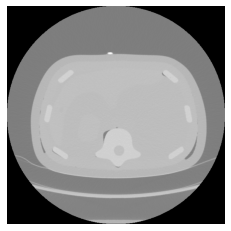

In [50]:
img = sitk.ReadImage(series_file_names[selected_series])
# Display the image slice from the middle of the stack, z axis
z = img.GetDepth()//2
print(z) ### printing image index for reference
plt.imshow(sitk.GetArrayViewFromImage(img)[z,:,:], cmap=plt.cm.Greys_r)
plt.axis('off');

<p>This is what the individual image parts look like.</p>

In [51]:
from IPython.core.display import Image, display
display(Image(url='ct_mri_image_141.png', width=200, unconfined=True))

# Adjusting Intensity Code

In [52]:
%matplotlib notebook
import gui

from downloaddata import fetch_data as fdata
from utilities import parameter_space_regular_grid_sampling, similarity3D_parameter_space_regular_sampling, eul2quat

OUTPUT_DIR = 'output'

data = [sitk.ReadImage(fdata("training_001_ct.mha")),
        sitk.ReadImage(fdata("training_001_mr_T1.mha"))]
# Comment out the following lines if you want to work in 3D. Note that in 3D some of the notebook visualizations are 
# disabled. 
data = [data[0][:,:,data[0].GetDepth()//2], data[1][:,:,data[1].GetDepth()//2]]
dimension = 2

Fetching training_001_ct.mha
Fetching training_001_mr_T1.mha


<IPython.core.display.Javascript object>


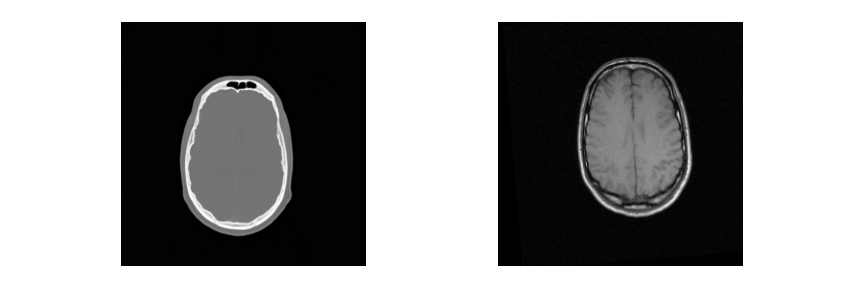

In [53]:
def disp_images(images, fig_size, wl_list=None):
    if images[0].GetDimension()==2:
      gui.multi_image_display2D(image_list=images, figure_size=fig_size, window_level_list=wl_list)
    else:
      gui.MultiImageDisplay(image_list=images, figure_size=fig_size, window_level_list=wl_list)
    
disp_images(data, fig_size=(6,2))

<IPython.core.display.Javascript object>


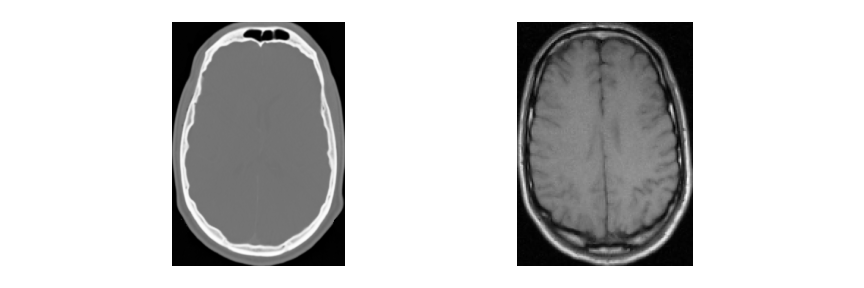

In [54]:
def threshold_based_crop_and_bg_median(image):
    '''
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box and compute the background 
    median intensity.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.
        Background median intensity value.
    '''
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 0
    outside_value = 255
    bin_image = sitk.OtsuThreshold(image, inside_value, outside_value)

    # Get the median background intensity
    label_intensity_stats_filter = sitk.LabelIntensityStatisticsImageFilter()
    label_intensity_stats_filter.SetBackgroundValue(outside_value)
    label_intensity_stats_filter.Execute(bin_image,image)
    bg_median = label_intensity_stats_filter.GetMedian(inside_value)
    
    # Get the bounding box of the anatomy
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()    
    label_shape_filter.Execute(bin_image)
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return bg_median, sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)])
    

bg_medians, modified_data = zip(*[threshold_based_crop_and_bg_median(img) for img in data])

disp_images(modified_data, fig_size=(6,2))

Run this cell three times, uncommenting a new denoted part each time.

In [57]:
dimension = data[0].GetDimension()

# Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
reference_physical_size = np.zeros(dimension)
for img in data:
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx  else mx for sz,spc,mx in zip(img.GetSize(), img.GetSpacing(), reference_physical_size)]

# Create the reference image with a zero origin, identity direction cosine matrix and dimension     
reference_origin = np.zeros(dimension)
reference_direction = np.identity(dimension).flatten()

# Select arbitrary number of pixels per dimension, smallest size that yields desired results 
# or the required size of a pretrained network (e.g. VGG-16 224x224), transfer learning. This will 
# often result in non-isotropic pixel spacing.
reference_size = [128]*dimension 
reference_spacing = [ phys_sz/(sz-1) for sz,phys_sz in zip(reference_size, reference_physical_size) ]

# Another possibility is that you want isotropic pixels, then you can specify the image size for one of
# the axes and the others are determined by this choice. Below we choose to set the x axis to 128 and the
# spacing set accordingly. 
# Uncomment the following lines to use this strategy.
reference_size_x = 128
reference_spacing = [reference_physical_size[0]/(reference_size_x-1)]*dimension
reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

reference_image = sitk.Image(reference_size, data[0].GetPixelIDValue())
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)

# Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as 
# this takes into account size, spacing and direction cosines. For the vast majority of images the direction 
# cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the 
# spacing will not yield the correct coordinates resulting in a long debugging session. 
reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

In [58]:
def augment_images_spatial(original_image, reference_image, T0, T_aug, transformation_parameters,
                    output_prefix, output_suffix,
                    interpolator = sitk.sitkLinear, default_intensity_value = 0.0):
    '''
    Generate the resampled images based on the given transformations.
    Args:
        original_image (SimpleITK image): The image which we will resample and transform.
        reference_image (SimpleITK image): The image onto which we will resample.
        T0 (SimpleITK transform): Transformation which maps points from the reference image coordinate system 
            to the original_image coordinate system.
        T_aug (SimpleITK transform): Map points from the reference_image coordinate system back onto itself using the
               given transformation_parameters. The reason we use this transformation as a parameter
               is to allow the user to set its center of rotation to something other than zero.
        transformation_parameters (List of lists): parameter values which we use T_aug.SetParameters().
        output_prefix (string): output file name prefix (file name: output_prefix_p1_p2_..pn_.output_suffix).
        output_suffix (string): output file name suffix (file name: output_prefix_p1_p2_..pn_.output_suffix).
        interpolator: One of the SimpleITK interpolators.
        default_intensity_value: The value to return if a point is mapped outside the original_image domain.
    '''
    all_images = [] # Used only for display purposes in this notebook.
    for current_parameters in transformation_parameters:
        T_aug.SetParameters(current_parameters)        
        # Augmentation is done in the reference image space, so we first map the points from the reference image space
        # back onto itself T_aug (e.g. rotate the reference image) and then we map to the original image space T0.
        T_all = sitk.CompositeTransform([T0, T_aug])
        aug_image = sitk.Resample(original_image, reference_image, T_all,
                                  interpolator, default_intensity_value)
        sitk.WriteImage(aug_image, output_prefix + '_' + 
                        '_'.join(str(param) for param in current_parameters) +'_.' + output_suffix)
         
        all_images.append(aug_image) # Used only for display purposes in this notebook.
    return all_images # Used only for display purposes in this notebook.

This part creates a side-by-side rotated set of images that you can adjust the intensity of using a slider to select which slice. Move the image slice slider to watch the brain jump around!

<IPython.core.display.Javascript object>


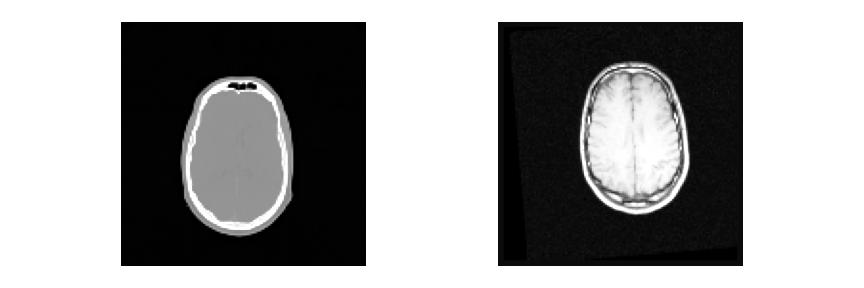

In [59]:
if dimension == 2:
    # The parameters are scale (+-10%), rotation angle (+-10 degrees), x translation, y translation
    transformation_parameters_list = parameter_space_regular_grid_sampling(np.linspace(0.9,1.1,3),
                                                                           np.linspace(-np.pi/18.0,np.pi/18.0,3),
                                                                           np.linspace(-10,10,3),
                                                                           np.linspace(-10,10,3))
    aug_transform = sitk.Similarity2DTransform()
else:    
    transformation_parameters_list = similarity3D_parameter_space_regular_sampling(np.linspace(-np.pi/18.0,np.pi/18.0,3),
                                                                                   np.linspace(-np.pi/18.0,np.pi/18.0,3),
                                                                                   np.linspace(-np.pi/18.0,np.pi/18.0,3),
                                                                                   np.linspace(-10,10,3),
                                                                                   np.linspace(-10,10,3),
                                                                                   np.linspace(-10,10,3),
                                                                                   np.linspace(0.9,1.1,3))
    aug_transform = sitk.Similarity3DTransform()

all_images = []
for index,img in enumerate(data):
    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.CompositeTransform(transform)
    centered_transform.AddTransform(centering_transform)

    # Set the augmenting transform's center so that rotation is around the image center.
    aug_transform.SetCenter(reference_center)
    
    generated_images = augment_images_spatial(img, reference_image, centered_transform, 
                                              aug_transform, transformation_parameters_list, 
                                              os.path.join(OUTPUT_DIR, 'spatial_aug'+str(index)), 
                                              'mha', default_intensity_value=bg_medians[index])
    
    if dimension==2: # in 2D we join all of the images into a 3D volume which we use for display.
        all_images.append(sitk.JoinSeries(generated_images))
# If working in 2D, display the resulting set of images.    
if dimension==2:
    gui.MultiImageDisplay(image_list=all_images, shared_slider=True, figure_size=(6,2))

# Registration Specific Code

In [60]:
import SimpleITK as sitk
from downloaddata import fetch_data as fdata
%matplotlib notebook
import gui
import registration_gui as rgui

import numpy as np
import os
OUTPUT_DIR = 'output'

The image we are writing to is defined as the "fixed" image and the other is the "moving" image.

Fetching training_001_ct.mha
Fetching training_001_mr_T1.mha


<IPython.core.display.Javascript object>


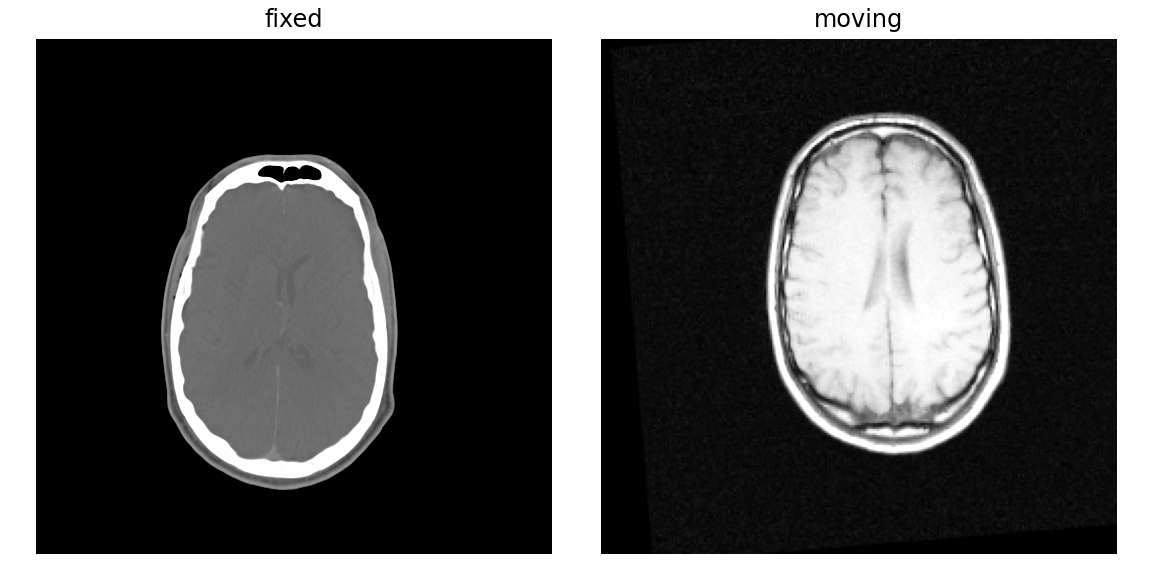

In [61]:
fixed_image =  sitk.ReadImage(fdata("training_001_ct.mha"), sitk.sitkFloat32)
moving_image = sitk.ReadImage(fdata("training_001_mr_T1.mha"), sitk.sitkFloat32)

ct_window_level = [835,162]
mr_window_level = [1036,520]

gui.MultiImageDisplay(image_list = [fixed_image, moving_image],                   
                      title_list = ['fixed', 'moving'], figure_size=(8,4), window_level_list=[ct_window_level, mr_window_level]);

<IPython.core.display.Javascript object>


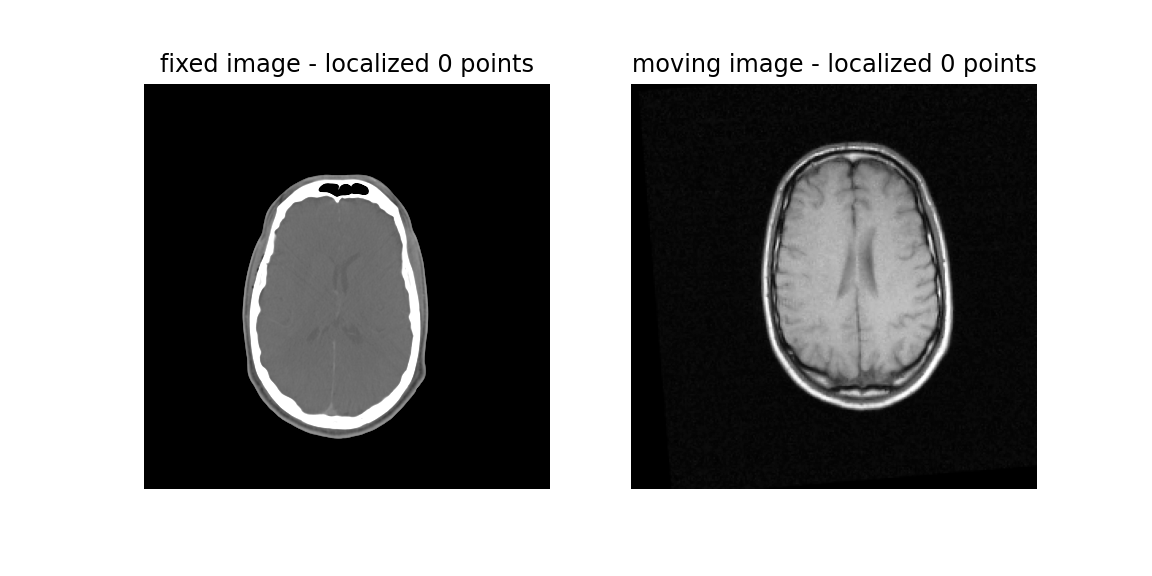

In [62]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), known_transformation=initial_transform, fixed_window_level=ct_window_level, moving_window_level=mr_window_level);

<IPython.core.display.Javascript object>


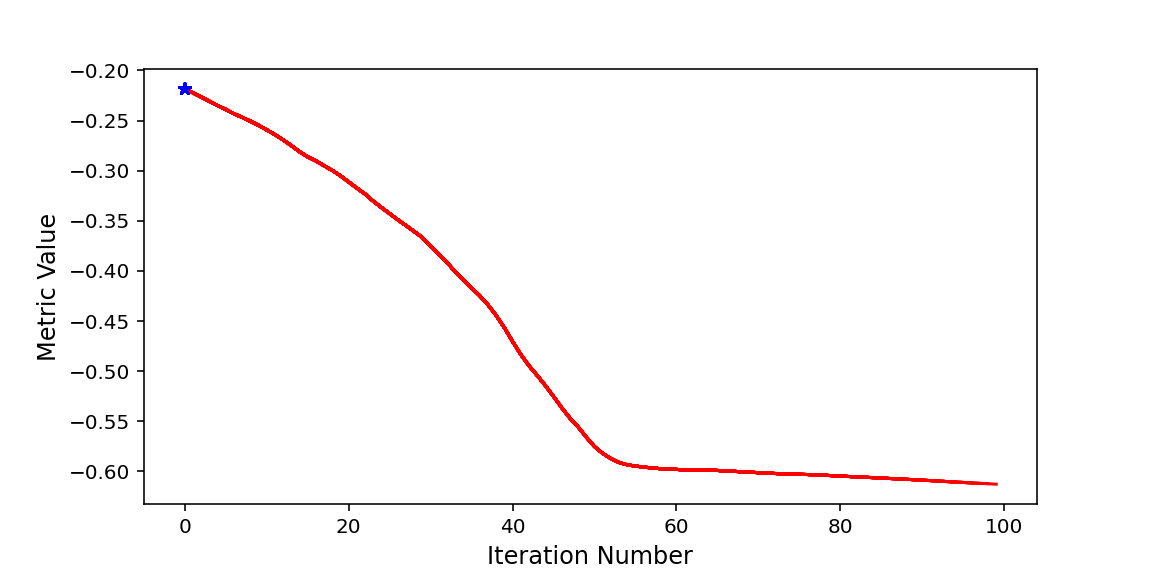

Final metric value: -0.6127365509495225
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.


In [71]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)

### UNCOMMENT THE LINE BELOW FOR CELL RUN 2
# registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
### UNCOMMENT THE THREE LINES BELOW FOR CELL RUN 3
# registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
# registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
# registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method))

final_transform = registration_method.Execute(fixed_image, moving_image)

# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

<IPython.core.display.Javascript object>


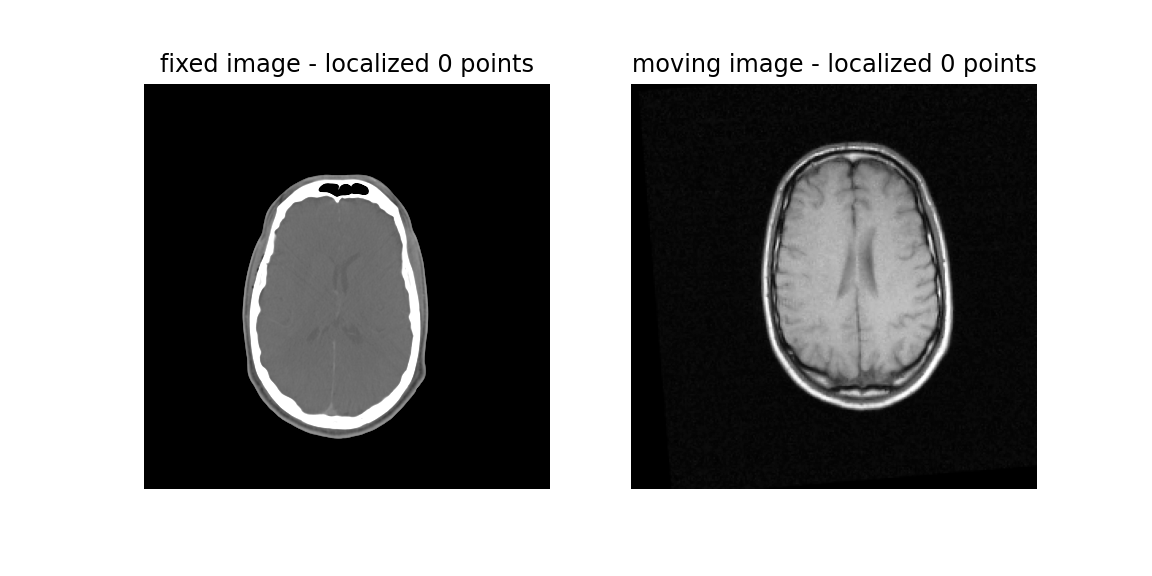

In [72]:
gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), known_transformation=final_transform,fixed_window_level=ct_window_level, moving_window_level=mr_window_level);

This creates a .mha image that 

This cell writes the registered image (.mha file) to the output folder in SimpleITK which can be opening using Fiji.

In [73]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
sitk.WriteImage(moving_resampled, os.path.join(OUTPUT_DIR, 'RIRE_training_001_mr_T1_resampled.mha'))
sitk.WriteTransform(final_transform, os.path.join(OUTPUT_DIR, 'RIRE_training_001_CT_2_mr_T1.tfm'))